# CMIP6 Convert Units

**Following steps are included in this script:**

1. Load netCDF files
2. Convert Units to Specified Format
3. Save and replace netcdf files

In [80]:
# ========== Packages ==========
import xarray as xr
import numpy as np
import dask
import os
from dask.delayed import delayed
import pandas as pd
import glob
import cftime

from __future__ import annotations

import xarray as xr

import xclim.indices
from xclim import testing

### Functions

In [48]:
def create_log(ds, var, old_unit):
        if 'log' in ds.attrs:
            log_old = ds.attrs['log']
            ds.attrs['log'] = f'Unit of {var} converted from {old_unit} to {ds[var].units}. // {log_old}'
        else:
            ds.attrs['log'] = f'Unit of {var} converted from {old_unit} to {ds[var].units}.'

        print(f"Unit of {var} converted from {old_unit} to {ds[var].units}.")
        return ds

In [49]:
def save_file(save_file, folder, save_var=True):
    """
    Save files as netCDF.

    Args:
        savefile (dict or dataset): Dictionary of xarray datasets or dataset.
        folder (string): Name of folder data is saved in.
        save_var (boolean): If True, data is saved separately for each variable. If false, one file is saved with all variables.
        

    Returns:
        nc_out: Path were data is saved in.
    """
    
    if save_var:
        for key, ds in ds_dict.items():
            for var in ds:
                # Variable to keep
                variable_to_keep = var
                dimensions_to_keep = {'time', 'lat', 'lon'}
                coordinates_to_keep = {'time', 'lat', 'lon'}

                if any('depth' in ds[var].dims for var in ds.variables):
                    dimensions_to_keep.add('depth')
                    coordinates_to_keep.add('depth')

                # Create a new dataset with only the desired variable
                ds_var = ds[[variable_to_keep]]

                # Keep only the desired dimensions
                ds_var = ds_var.isel({dim: slice(None) for dim in dimensions_to_keep.intersection(ds_var.dims)})

                # Set the desired coordinates
                coords_to_set = set(ds_var.variables).intersection(coordinates_to_keep)
                ds_var = ds_var.set_coords(list(coords_to_set))

                savepath = f'../../data/CMIP6/{ds_var.experiment_id}/{folder}/{ds_var.table_id}/{var}/'
                filename = f'CMIP.{ds_var.source_id}.{ds_var.experiment_id}.{var}.regridded.nc'
                nc_out = os.path.join(savepath, filename)
                os.makedirs(savepath, exist_ok=True) 
                if os.path.exists(nc_out):
                    os.remove(nc_out)
                    print(f"File  with path: {nc_out} removed")
                    
                # Save to netcdf file
                with dask.config.set(scheduler='threads'):
                    ds_var.to_netcdf(nc_out)
                    print(f"File with path: {nc_out} saved")

    return nc_out

In [50]:
# ========= Create a helper function to open the dataset ========
def open_dataset(filename):
    ds = xr.open_dataset(filename)
    return ds

# Define a helper function to open and merge datasets
def open_and_merge_datasets(folder, model, experiment_id, temp_res, variables):
    filepaths = []
    for var in variables:
        path = f'../../data/CMIP6/{experiment_id}/{folder}/{temp_res}/{var}'
        fp = glob.glob(os.path.join(path, f'CMIP.{model}.{experiment_id}.{var}.regridded.nc'))
        if fp:
            filepaths.append(fp[0])
        else:
            print(f"No file found for variable '{var}' in model '{model}'.")
            print(fp)

    datasets = [xr.open_dataset(fp) for fp in filepaths]
    ds = xr.merge(datasets)
    return ds

In [78]:
def compute_RX5day_seasonal(ds, season):
    seasons_to_months = {
        'winter': [12, 1, 2],  # December of the previous year, January and February of the current year
        'spring': [3, 4, 5],
        'summer': [6, 7, 8],
        'fall': [9, 10, 11],
    }
    selected_months = seasons_to_months[season]
    
    start_year = ds.time.dt.year.values[0]
    end_year = ds.time.dt.year.values[-1] 
    
    rx5day_results = []
    time_coords = []

    for year in range(start_year, end_year + 1):
        # Special handling for winter season edge cases
        if season == 'winter':
            if year == start_year:
                # Skip the first winter season if the dataset doesn't include December of the previous year
                continue
            if year == end_year:
                # Skip the last winter season if the dataset doesn't include January and February of the next year
                continue
            # Adjust the range to include December of the previous year
            start_date = f"{year-1}-12-01"
            end_date = f"{year}-02-28"
        else:
            start_date = f"{year}-{selected_months[0]:02d}-01"
            last_month = selected_months[-1]
            end_date = f"{year}-{last_month:02d}-{pd.Period(f'{year}-{last_month}', 'M').days_in_month}"
        
        # Select the data for the current year and season
        ds_season = ds.sel(time=slice(start_date, end_date))
        ds_season = ds_season.where(ds_season['time.month'].isin(selected_months), drop=True)
        
        # Calculate the rolling 5-day sum of precipitation
        rolling_sum = ds_season['pr'].rolling(time=5, min_periods=5).sum()
        
        # Find the maximum 5-day precipitation sum for the season
        rx5day_max = rolling_sum.max(dim='time', skipna=True)

        rx5day_results.append(rx5day_max)
        
        # Generate a representative cftime.DatetimeNoLeap object for the season/year
        if season == 'winter':
            # Use January 1st of the actual year for winter
            time_coords.append(cftime.DatetimeNoLeap(year, 1, 1))
        else:
            # Use the first month of the season for other seasons
            time_coords.append(cftime.DatetimeNoLeap(year, selected_months[0], 1))
    
    # Combine results into a single DataArray
    #if season == 'winter':
    #    rx5day_seasonal = xr.concat(rx5day_results, pd.Index([year for year in range(start_year + 1, end_year)], name='time'))
    #else:
    #    rx5day_seasonal = xr.concat(rx5day_results, pd.Index([year for year in range(start_year, end_year + 1)], name='time'))
    
    # Combine results into a single DataArray with cftime.DatetimeNoLeap time coordinate
    rx5day_seasonal = xr.concat(rx5day_results, dim='time')
    rx5day_seasonal['time'] = time_coords

    
    # Assign attributes
    rx5day_seasonal.attrs['units'] = 'mm'
    rx5day_seasonal.attrs['cell_methods'] = 'area: time: mean (interval: 5 minutes) time: maximum over days'
    rx5day_seasonal.attrs['history'] = f'[2024-02-20 16:59:26] RX5day compute_RX5day_seasonal (pr=pr, freq={season})'
    rx5day_seasonal.attrs['long_name'] = 'Highest 5-day precipitation amount'
    rx5day_seasonal.attrs['standard_name'] = 'lwe_thickness_of_precipitation_amount'
    rx5day_seasonal.attrs['description'] = 'Annual maximum 5-day total precipitation amount.'
    
    return rx5day_seasonal

In [52]:
def compute_RX5day(ds_dict, freq):
    new_ds_dict = {}
    
    for name, ds in ds_dict.items():
        # Compute the RX5day index
        if freq == 'YS' or freq == 'MS':
            rx5day = xclim.indicators.icclim.RX5day(pr=ds.pr, freq=freq)
        elif freq == 'winter' or freq == 'spring' or freq == 'summer' or freq == 'fall':
            rx5day = compute_RX5day_seasonal(ds, freq)

        # Create a new dataset with the computed RX5day
        new_ds = xr.Dataset({'RX5day': rx5day})
        
        # Assigning time coordinates from the computed RX5day to the new dataset
        new_ds = new_ds.assign_coords(time=rx5day.time)
        
        # Store the new dataset in the dictionary
        new_ds_dict[name] = new_ds

        new_ds_dict[name].attrs = ds.attrs
        
        new_ds_dict[name].attrs['table_id'] = freq

    return new_ds_dict

### 1. Load netCDF files

In [109]:
# ========= Define period, models and path ==============
variable=['pr']
          
experiment_id = 'historical'
source_id = ['BCC-CSM2-MR', 
             'CAMS-CSM1-0', 
             ##'CanESM5-CanOE', 
             'CanESM5', 
             'CESM2-WACCM',
             'CNRM-CM6-1', 
             'CNRM-ESM2-1',
             'GFDL-ESM4',
             ##'GISS-E2-1-G',
             'MIROC-ES2L', 
             'MPI-ESM1-2-LR',
             'NorESM2-MM',
             ##'TaiESM1',
             'UKESM1-0-LL'
            ] #
#source_id = ['CNRM-CM6-1']#, 'CAMS-CSM1-0', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1',  'GFDL-ESM4', 'GISS-E2-1-G', 'IPSL-CM6A-LR', 'MIROC-ES2L',  'MPI-ESM1-2-LR', 'UKESM1-0-LL'] #
folder='preprocessed'
temp_res = 'day' # mon

# ========= Use Dask to parallelize computations ==========
dask.config.set(scheduler='processes')

# Create dictionary using a dictionary comprehension and Dask
ds_dict = dask.compute({model: open_and_merge_datasets(folder, model, experiment_id, temp_res, variable) for model in source_id})[0]

['BCC-CSM2-MR']


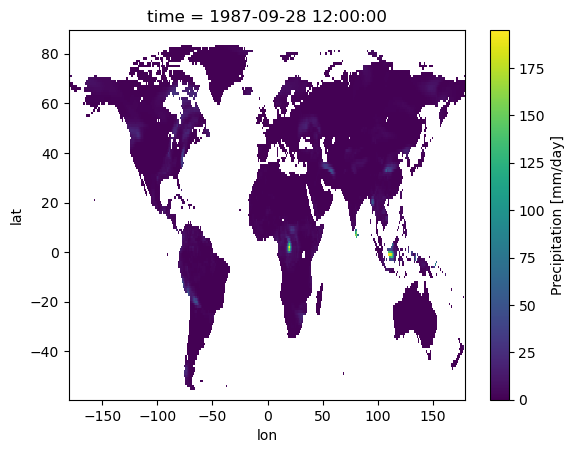

In [9]:
# ========= Have a look into the dictionary =======
print(list(ds_dict.keys()))
ds_dict[list(ds_dict.keys())[0]][variable[0]].isel(time=1000).plot()

### 2. Compute Precipitation Index

In [ ]:
ds_dict = compute_RX5day(ds_dict, freq='winter') # 'MS', 'winter','spring','summer','fall'

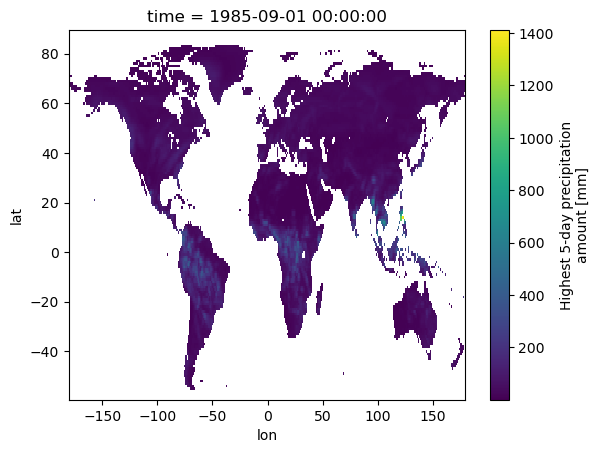

In [101]:
ds_dict[list(ds_dict.keys())[0]].RX5day.isel(time=0).plot()

In [100]:
ds_dict[list(ds_dict.keys())[0]]

<xarray.Dataset>
Dimensions:  (lat: 149, lon: 360, time: 30)
Coordinates:
  * lat      (lat) int64 -59 -58 -57 -56 -55 -54 -53 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 -180 -179 -178 -177 -176 -175 ... 175 176 177 178 179
  * time     (time) object 1985-09-01 00:00:00 ... 2014-09-01 00:00:00
Data variables:
    RX5day   (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/68)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    Standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            2289.0
    comment:                          The model integration starts from the p...
    ...                               ...
    intake_esm_attrs:units:           kg m-2 s-1
    intake_esm_attrs:realm:           atmos
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP.BCC-CSM2-MR.historical.day.gn
    log:                              Unit of pr converted from kg/m²/s to mm...
    regrid_method:                    conservative

### 3. Save and replace netcdf files

In [ ]:
nc_out = save_file(ds_dict, folder=folder)

In [ ]:
# =========== Check stored file ==============
xr.open_dataset(nc_out)